In [1]:
import dask
import pystac_client
import leafmap
import geogif
import stackstac
import numpy as np
import matplotlib
import pystac_client
import matplotlib.pyplot as plt
from pystac_client import Client

### Print package versions

In [2]:
print("Numpy version", np.__version__)
print("Matplotlib version", matplotlib.__version__)
print("Pystac client version",pystac_client.__version__)
print("dask version",dask.__version__)
print("stackstac version",stackstac.__version__)

Numpy version 1.24.3
Matplotlib version 3.7.1
Pystac client version 0.7.1
dask version 2023.5.0
stackstac version 0.5.0


### Connect to API using pystac client

In [3]:
api_url = "https://earth-search.aws.element84.com/v1"
client = Client.open(api_url)

### Create a bounding box to make a search

In [4]:
bbox = (35.16402630997399, 11.240162235950265, 35.17440912681519,11.249823496541282)

### Get sentinel2 collection that intersect with the bounding box for a given range of dates after filtering based on a given query

In [5]:
search_results = client.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2017-01-01/2022-12-31",
    query= ["eo:cloud_cover<50"]
)

In [6]:
items = search_results.item_collection()
len(items)

350

### Create a local cluster using dask

In [7]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client2 = Client(cluster)
client2

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35861,Workers: 4
Dashboard: /user/smuda@clarku.edu/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:36043,Total threads: 2
Dashboard: /user/smuda@clarku.edu/proxy/35247/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:34597,


### Use stackstac to turn a STAC collection into a lazy xarray.DataArray, backed by dask.

In [8]:
stack = stackstac.stack(items, bounds_latlon=bbox)
stack

<xarray.DataArray 'stackstac-43f61d59090fd5fa75cecd9e9bcbe445' (time: 350,
                                                                band: 32,
                                                                y: 109, x: 115)>
dask.array<fetch_raster_window, shape=(350, 32, 109, 115), dtype=float64, chunksize=(1, 1, 109, 115), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 7.362e+05 ... 7.374e+05
  * y                                        (y) float64 1.244e+06 ... 1.243e+06
    eo:cloud_cover                           (time) object 0.484458 ... 21.2099
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32636
Attributes:
    spec:        RasterSpec(epsg=32636, bounds=(736250.0, 1243400.0, 737400.0...
    crs:         epsg:32636
    transform:   | 10.00, 0.00, 736250.00|\n| 0.00,-10.00, 1244490.00|\n| 0.0...
    resolution:  10.0

### Select Green and NIR bands to compute NDWI

In [24]:
green, nir = stack.sel(band="nir"), stack.sel(band="green")
ndwi = (green - nir) / (green + nir)

### Calculate mean NDWI at each time point

In [25]:
mean_ndwi = ndwi.mean(dim=["x","y"], skipna = True)
mean_ndwi

<xarray.DataArray 'stackstac-43f61d59090fd5fa75cecd9e9bcbe445' (time: 350)>
dask.array<mean_agg-aggregate, shape=(350,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2017-01-05...
    id                                       (time) <U24 'S2A_36PYT_20170105_...
    eo:cloud_cover                           (time) object 0.484458 ... 21.2099
    s2:thin_cirrus_percentage                (time) object 0.483724 ... 6.301535
    s2:product_uri                           (time) <U65 'S2A_MSIL2A_20170105...
    s2:snow_ice_percentage                   int64 0
    ...                                       ...
    s2:not_vegetated_percentage              (time) float64 93.5 93.16 ... 52.63
    platform                                 (time) <U11 'sentinel-2a' ... 's...
    s2:mgrs_tile                             (time) object None None ... None
    raster:bands                             object None
    gsd                                      object 10
    epsg                                     int64 32636

### Plot mean NDWI as a function of time

While computing NDWI, for some pixels, the denominator was calculated as zero, probably because the values for green band and nir band are either zero or not available. This resulted in NDWI values to be infinite, and mean NDWI values for some time points to be infinite as well. Therefore the plot is not as one would expect.
Ignoring the missing/zero values will resolve the problem.

(-1.0, 1.0)

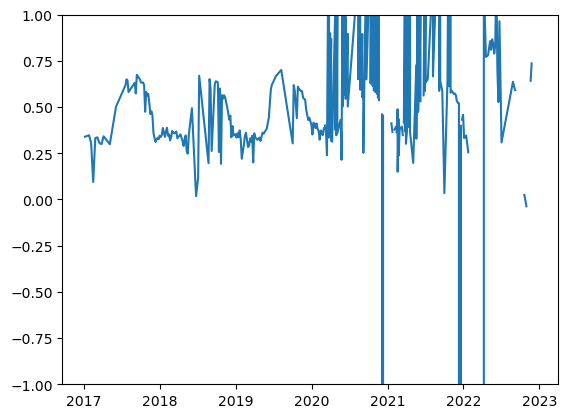

In [26]:
plt.plot(stack.time.values,mean_ndwi.compute())
plt.ylim(-1,1)